# 🚂 **Analyse du réseau ferré de la SNCF: Comment expliquer les retards permanents de la compagnie française ?** 🚂



Comme tout bon étudiant provincial du plateau de Saclay, nous avons régulièrement eu à faire aux retards interminables des trains de la SNCF. A l'heure où le train est de plus en plus destiné à remplacer l'aviation civile ultra-polluante, nous avons voulu analyser l'évolution et les causes des retards que subissent fréquemment les usagers du réseau ferré français. 

Pour cela, nous avons basé notre analyse sur différentes bases de données rendues publiques et entretenues par la SNCF elle même. Ce travail a vocation à répondre aux exigences du cours de **Python pour la Data Science** de 2ème année de l'ENSAE Paris et reprend la même articulation en 3 axes: 
- Récupération et traitement des données
- Analyse descriptive et représentation graphique
- Modélisation 

Tout au long de ce notebook, nous ferons appel à des fonctions utiles définies dans le fichier **fonctions.py**. A la fin du travail d'analyse, nous vous proposons également un petit jeu intéractif bonus à ouvrir dans un autre éditeur de code que Jupyter. 

## **1. Récupération et traitement des données de l'API de la SNCF**

On commence par importer les librairies et les fonction définies dans le fichier **fonction.py**

In [42]:
from fonctions import *

Nous avons commencé notre travail sur le site de l'API SNCF *https://ressources.data.sncf.com/api/v2/console*. Il propose d'accéder à plus de 216 datasets qui regroupent différents types de données concernant la SNCF. Le premier fichier que nous avons étudié est le **Catalogue** qui présente tous les autres datasets disponnibles sur l'API. C'est à partir de ce Catalogue que nous avons pu identifier les différents datasets utiles à nos analyses.

In [43]:
df_catalogue = importer("https://ressources.data.sncf.com/api/v2/catalog/exports/json?limit=-1&offset=0&timezone=UTC")
pd.DataFrame(df_catalogue['dataset_id']).head(2)

,dataset_id
0,rapports-irc
1,info-ges


### **1.1 Analyse du réseau ferré de la SNCF**

Pour commencer notre analyse, nous avons voulu identifier les stations SNCF les plus fréquentées afin d'avoir une meilleure idée du maillage du réseau ferré français. Nous allons chercher les données qui nous interessent dans les datasets **liste_des_gares** et **frequentations_gares** disponnibles sur l'API de la SNCF.


#### **1.1.1 Importation des données**

In [44]:
#importation de la liste des gares, API SNCF
df_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [45]:
#importation des données sur la frequentation des gares, API SNCF
df_freq_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121


In [46]:
#comparaison du nombre de données (moins de données sur la fréquentation)
print(len(df_freq_gares))
print(len(df_gares))

2970
3819


#### **1.1.2 Constitution de la base de données (nettoyage, fusion, et concaténation de données)**

On va travailler sur les 2 datasets importés afin de créer notre base de données des gares SNCF les plus fréquentées.

In [47]:
#Harmonisation du nom de la colonne code_uic en vue du merge
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [48]:
#On regarde quelles gares du dataframe "liste des gares" ne sont pas dans le dataframe "frequentations"
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']].head(2)

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir


Ce ne sont que des petites gares et comme nous nous intéressons aux gares les plus fréquentées, non allons considérer seulement celles du dataset des fréquentation.

In [49]:
#Fusion des dataframes sur la base de df_freq_gares avec un left merge
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]
df_gares_merged.head(2)

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84
0,87481614,22773,Abbaretz,-1.524313,47.555462
1,87757559,15390,Agay,6.856677,43.431734


In [50]:
#Elimination des gares dont la frequentation est nulle
df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)

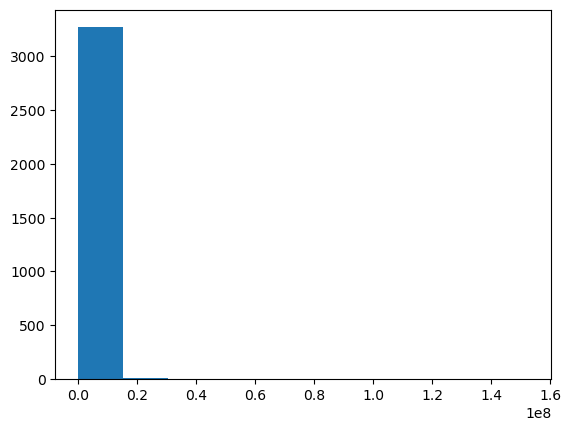

In [51]:
#Visualisation de la répartition des fréquentations par gare
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.show()

On remarque que pour mieux apprécier les fréquentations, il est nécessaire de passer au log.